In [22]:
import model
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os

In [23]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
network = model.get_network(model.Network.GROUP_NORM).to(device)
summary(network, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         GroupNorm-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         GroupNorm-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        GroupNorm-12            [-1, 8, 14, 14]              16
    

/content/model.py:114: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [24]:
torch.manual_seed(1)
batch_size = 64

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [25]:
from tqdm import tqdm

train_losses = []
train_acc = []
test_losses = []
test_acc = []
gn_train_losses, gn_train_acc, gn_test_losses, gn_test_acc = [], [], [], []
ln_train_losses, ln_train_acc, ln_test_losses, ln_test_acc = [], [], [], []
bn_train_losses, bn_train_acc, bn_test_losses, bn_test_acc = [], [], [], []


def train(model, device, train_loader, optimizer, epoch, use_lambda = False):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    lambda_l1 = 0.0004

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)

        if use_lambda :
          l1 = 0
          for params in model.parameters():
            l1 = l1 + params.abs().sum()
          '''  
          #lambda_l1 = 0.0004
          if lambda_l1 == 0: #First epoch lambda calculation
            lambda_l1 = loss/(l1*10)
            print('loss: ', loss)
            print('l1: ', l1)
            print('lambda_l1: ', lambda_l1)
          '''
          loss = loss + lambda_l1*l1

        train_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
        train_acc.append(100*correct/processed)

    return train_losses, train_acc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [26]:
network = model.get_network(model.Network.GROUP_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    gn_train_losses, gn_train_acc = train(network, device, train_loader, optimizer, epoch)
    gn_test_losses, gn_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.27026161551475525 batch_id=937 Accuracy=87.27%: 100%|██████████| 938/938 [00:27<00:00, 33.83it/s]



Test set: Average loss: 0.0960, Accuracy: 9711/10000 (97.11%)



Epoch=2 Loss=0.15303342044353485 batch_id=937 Accuracy=96.92%: 100%|██████████| 938/938 [00:21<00:00, 43.38it/s]



Test set: Average loss: 0.0501, Accuracy: 9860/10000 (98.60%)



Epoch=3 Loss=0.06850352883338928 batch_id=937 Accuracy=97.60%: 100%|██████████| 938/938 [00:21<00:00, 43.87it/s]



Test set: Average loss: 0.0410, Accuracy: 9879/10000 (98.79%)



Epoch=4 Loss=0.029781468212604523 batch_id=937 Accuracy=97.94%: 100%|██████████| 938/938 [00:22<00:00, 40.97it/s]



Test set: Average loss: 0.0343, Accuracy: 9895/10000 (98.95%)



Epoch=5 Loss=0.03474287688732147 batch_id=937 Accuracy=98.12%: 100%|██████████| 938/938 [00:21<00:00, 43.43it/s]



Test set: Average loss: 0.0371, Accuracy: 9880/10000 (98.80%)



Epoch=6 Loss=0.06373993307352066 batch_id=937 Accuracy=98.19%: 100%|██████████| 938/938 [00:21<00:00, 43.34it/s]



Test set: Average loss: 0.0318, Accuracy: 9906/10000 (99.06%)



Epoch=7 Loss=0.17453797161579132 batch_id=937 Accuracy=98.42%: 100%|██████████| 938/938 [00:21<00:00, 43.88it/s]



Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)



Epoch=8 Loss=0.05069108307361603 batch_id=937 Accuracy=98.55%: 100%|██████████| 938/938 [00:21<00:00, 43.65it/s]



Test set: Average loss: 0.0298, Accuracy: 9899/10000 (98.99%)



Epoch=9 Loss=0.09064511209726334 batch_id=937 Accuracy=98.51%: 100%|██████████| 938/938 [00:21<00:00, 43.74it/s]



Test set: Average loss: 0.0283, Accuracy: 9906/10000 (99.06%)



Epoch=10 Loss=0.17357614636421204 batch_id=937 Accuracy=98.69%: 100%|██████████| 938/938 [00:21<00:00, 43.77it/s]



Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)



Epoch=11 Loss=0.013294675387442112 batch_id=937 Accuracy=98.64%: 100%|██████████| 938/938 [00:22<00:00, 42.43it/s]



Test set: Average loss: 0.0231, Accuracy: 9919/10000 (99.19%)



Epoch=12 Loss=0.015237477608025074 batch_id=937 Accuracy=98.79%: 100%|██████████| 938/938 [00:21<00:00, 43.68it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)



Epoch=13 Loss=0.0599377267062664 batch_id=937 Accuracy=98.87%: 100%|██████████| 938/938 [00:21<00:00, 44.18it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)



Epoch=14 Loss=0.02618277631700039 batch_id=937 Accuracy=98.77%: 100%|██████████| 938/938 [00:21<00:00, 44.26it/s]



Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)



Epoch=15 Loss=0.03442539647221565 batch_id=937 Accuracy=98.87%: 100%|██████████| 938/938 [00:21<00:00, 43.84it/s]



Test set: Average loss: 0.0233, Accuracy: 9925/10000 (99.25%)



In [27]:
network = model.get_network(model.Network.LAYER_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
         LayerNorm-3           [-1, 10, 28, 28]          15,680
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
         LayerNorm-7           [-1, 16, 28, 28]          25,088
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
        LayerNorm-12            [-1, 8, 14, 14]           3,136
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:211: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [28]:
#network = model.get_network(model.Network.LAYER_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    ln_train_losses, ln_train_acc = train(network, device, train_loader, optimizer, epoch)
    ln_test_losses, ln_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.3943309187889099 batch_id=937 Accuracy=88.72%: 100%|██████████| 938/938 [00:27<00:00, 34.24it/s]



Test set: Average loss: 0.0810, Accuracy: 9769/10000 (97.69%)



Epoch=2 Loss=0.058832798153162 batch_id=937 Accuracy=96.94%: 100%|██████████| 938/938 [00:20<00:00, 45.11it/s]



Test set: Average loss: 0.0472, Accuracy: 9857/10000 (98.57%)



Epoch=3 Loss=0.3692172169685364 batch_id=937 Accuracy=97.66%: 100%|██████████| 938/938 [00:20<00:00, 44.85it/s]



Test set: Average loss: 0.0384, Accuracy: 9884/10000 (98.84%)



Epoch=4 Loss=0.07799383997917175 batch_id=937 Accuracy=98.14%: 100%|██████████| 938/938 [00:20<00:00, 44.89it/s]



Test set: Average loss: 0.0344, Accuracy: 9891/10000 (98.91%)



Epoch=5 Loss=0.02110084518790245 batch_id=937 Accuracy=98.27%: 100%|██████████| 938/938 [00:21<00:00, 43.50it/s]



Test set: Average loss: 0.0307, Accuracy: 9904/10000 (99.04%)



Epoch=6 Loss=0.1437591016292572 batch_id=937 Accuracy=98.46%: 100%|██████████| 938/938 [00:20<00:00, 45.29it/s]



Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)



Epoch=7 Loss=0.059965066611766815 batch_id=937 Accuracy=98.53%: 100%|██████████| 938/938 [00:20<00:00, 45.09it/s]



Test set: Average loss: 0.0268, Accuracy: 9916/10000 (99.16%)



Epoch=8 Loss=0.008127904497087002 batch_id=937 Accuracy=98.63%: 100%|██████████| 938/938 [00:21<00:00, 43.47it/s]



Test set: Average loss: 0.0266, Accuracy: 9911/10000 (99.11%)



Epoch=9 Loss=0.04513375461101532 batch_id=937 Accuracy=98.74%: 100%|██████████| 938/938 [00:20<00:00, 45.39it/s]



Test set: Average loss: 0.0258, Accuracy: 9920/10000 (99.20%)



Epoch=10 Loss=0.020319625735282898 batch_id=937 Accuracy=98.75%: 100%|██████████| 938/938 [00:20<00:00, 46.03it/s]



Test set: Average loss: 0.0235, Accuracy: 9913/10000 (99.13%)



Epoch=11 Loss=0.008243116550147533 batch_id=937 Accuracy=98.81%: 100%|██████████| 938/938 [00:20<00:00, 45.22it/s]



Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)



Epoch=12 Loss=0.10386316478252411 batch_id=937 Accuracy=98.86%: 100%|██████████| 938/938 [00:20<00:00, 45.53it/s]



Test set: Average loss: 0.0238, Accuracy: 9918/10000 (99.18%)



Epoch=13 Loss=0.0031548310071229935 batch_id=937 Accuracy=98.91%: 100%|██████████| 938/938 [00:20<00:00, 45.15it/s]



Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)



Epoch=14 Loss=0.00873594917356968 batch_id=937 Accuracy=98.91%: 100%|██████████| 938/938 [00:20<00:00, 45.68it/s]



Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)



Epoch=15 Loss=0.0485687330365181 batch_id=937 Accuracy=98.94%: 100%|██████████| 938/938 [00:20<00:00, 45.07it/s]



Test set: Average loss: 0.0203, Accuracy: 9933/10000 (99.33%)



In [29]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
summary(network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             100
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
         Dropout2d-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,456
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
         Dropout2d-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             136
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
        Dropout2d-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

/content/model.py:308: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [30]:
network = model.get_network(model.Network.BATCH_NORM).to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

train_losses = []
train_acc = []
test_losses = []
test_acc = []

for epoch in range(1, 16):
    bn_train_losses, bn_train_acc = train(network, device, train_loader, optimizer, epoch, use_lambda = True)
    bn_test_losses, bn_test_acc = test(network, device, test_loader)

Epoch=1 Loss=0.41637444496154785 batch_id=937 Accuracy=90.04%: 100%|██████████| 938/938 [00:22<00:00, 41.13it/s]



Test set: Average loss: 0.0697, Accuracy: 9789/10000 (97.89%)



Epoch=2 Loss=0.38503971695899963 batch_id=937 Accuracy=96.66%: 100%|██████████| 938/938 [00:22<00:00, 41.32it/s]



Test set: Average loss: 0.0517, Accuracy: 9844/10000 (98.44%)



Epoch=3 Loss=0.2972959280014038 batch_id=937 Accuracy=97.16%: 100%|██████████| 938/938 [00:22<00:00, 41.52it/s]



Test set: Average loss: 0.0477, Accuracy: 9854/10000 (98.54%)



Epoch=4 Loss=0.6611180901527405 batch_id=937 Accuracy=97.25%: 100%|██████████| 938/938 [00:22<00:00, 41.53it/s]



Test set: Average loss: 0.0431, Accuracy: 9865/10000 (98.65%)



Epoch=5 Loss=0.24398651719093323 batch_id=937 Accuracy=97.42%: 100%|██████████| 938/938 [00:23<00:00, 40.23it/s]



Test set: Average loss: 0.0376, Accuracy: 9870/10000 (98.70%)



Epoch=6 Loss=0.4469282627105713 batch_id=937 Accuracy=97.48%: 100%|██████████| 938/938 [00:22<00:00, 41.18it/s]



Test set: Average loss: 0.0415, Accuracy: 9865/10000 (98.65%)



Epoch=7 Loss=0.22897346317768097 batch_id=937 Accuracy=97.36%: 100%|██████████| 938/938 [00:22<00:00, 41.51it/s]



Test set: Average loss: 0.0571, Accuracy: 9813/10000 (98.13%)



Epoch=8 Loss=0.4171452522277832 batch_id=937 Accuracy=97.47%: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]



Test set: Average loss: 0.0409, Accuracy: 9867/10000 (98.67%)



Epoch=9 Loss=0.29185277223587036 batch_id=937 Accuracy=97.56%: 100%|██████████| 938/938 [00:22<00:00, 41.35it/s]



Test set: Average loss: 0.0397, Accuracy: 9878/10000 (98.78%)



Epoch=10 Loss=0.22588683664798737 batch_id=937 Accuracy=97.62%: 100%|██████████| 938/938 [00:22<00:00, 41.01it/s]



Test set: Average loss: 0.0425, Accuracy: 9865/10000 (98.65%)



Epoch=11 Loss=0.2377592772245407 batch_id=937 Accuracy=97.53%: 100%|██████████| 938/938 [00:23<00:00, 40.42it/s]



Test set: Average loss: 0.0377, Accuracy: 9878/10000 (98.78%)



Epoch=12 Loss=0.21448864042758942 batch_id=937 Accuracy=97.62%: 100%|██████████| 938/938 [00:22<00:00, 40.84it/s]



Test set: Average loss: 0.0338, Accuracy: 9894/10000 (98.94%)



Epoch=13 Loss=0.1941608488559723 batch_id=937 Accuracy=97.61%: 100%|██████████| 938/938 [00:22<00:00, 40.88it/s]



Test set: Average loss: 0.0400, Accuracy: 9876/10000 (98.76%)



Epoch=14 Loss=0.1909678727388382 batch_id=937 Accuracy=97.53%: 100%|██████████| 938/938 [00:22<00:00, 41.41it/s]



Test set: Average loss: 0.0377, Accuracy: 9871/10000 (98.71%)



Epoch=15 Loss=0.2192317098379135 batch_id=937 Accuracy=97.64%: 100%|██████████| 938/938 [00:22<00:00, 41.18it/s]



Test set: Average loss: 0.0435, Accuracy: 9861/10000 (98.61%)



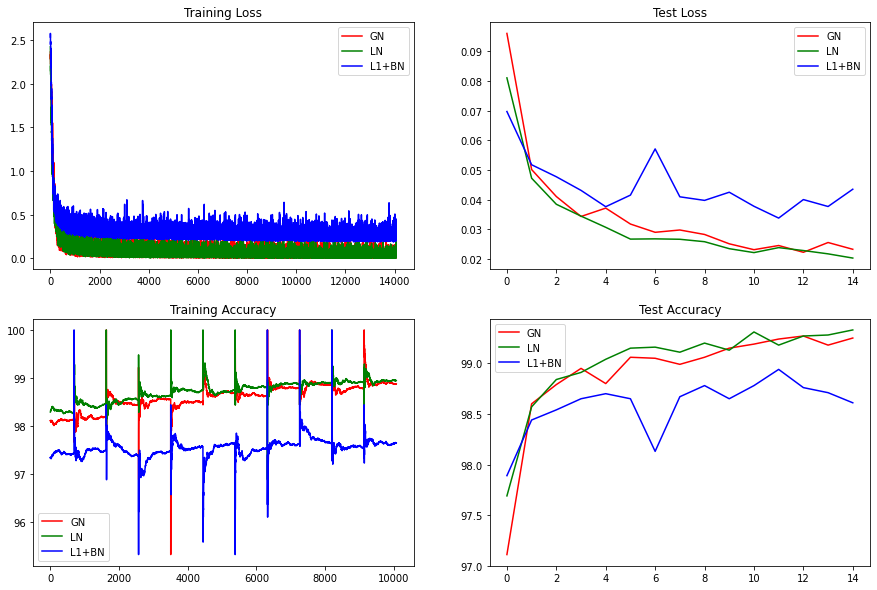

In [37]:
from torch.functional import Tensor
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(torch.stack(gn_train_losses).cpu().detach().numpy(), color='r', label='GN')
axs[0, 0].plot(torch.stack(ln_train_losses).cpu().detach().numpy(), color='g', label='LN')
axs[0, 0].plot(torch.stack(bn_train_losses).cpu().detach().numpy(), color='b', label='L1+BN')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(gn_train_acc[4000:], color='r', label='GN')
axs[1, 0].plot(ln_train_acc[4000:], color='g', label='LN')
axs[1, 0].plot(bn_train_acc[4000:], color='b', label='L1+BN')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(gn_test_losses, color='r', label='GN')
axs[0, 1].plot(ln_test_losses, color='g', label='LN')
axs[0, 1].plot(bn_test_losses, color='b', label='L1+BN')
axs[0, 1].set_title("Test Loss")
#axs[1, 1].plot(test_acc)
axs[1, 1].plot(gn_test_acc, color='r', label='GN')
axs[1, 1].plot(ln_test_acc, color='g', label='LN')
axs[1, 1].plot(bn_test_acc, color='b', label='L1+BN')
axs[1, 1].set_title("Test Accuracy")
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()
